In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc


Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

**Copied from Part 1:**
This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [9]:
labels_pd = pd.read_csv("labels.csv")
counts_pd = pd.read_csv("processed_counts.csv")

In [10]:
labels_pd.index = labels_pd['index']
labels_pd.drop("index", axis=1, inplace=True)
counts_pd.index = counts_pd['Unnamed: 0']
counts_pd.drop("Unnamed: 0", axis=1, inplace=True)

df = counts_pd.merge(labels_pd, left_index=True, right_index=True).dropna()
df

,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,EFHD2,...,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3,bulk_labels
AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,-0.525,...,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011,CD14+ Monocyte
AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490,Dendritic
AACACGTGGTCTTT-1,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,2.286,...,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490,CD56+ NK
AAGTGCACGTGCTA-1,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490,CD4+/CD25 T Reg
ACACGAACGGAGTG-1,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,1.932,...,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490,Dendritic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGGCACCTCCAACA-8,-0.326,-0.191,0.372,-0.584,-0.174,0.509,-0.451,2.160,-0.459,0.751,...,-0.532,1.758,1.578,0.055,-0.585,0.561,-0.21,0.543,2.593,Dendritic
TGTGAGTGCTTTAC-8,3.166,-0.191,-0.728,-1.200,-0.174,-0.531,-0.451,-0.486,-0.459,1.536,...,-0.532,-0.341,0.432,0.753,-0.585,-0.171,-0.21,1.268,-0.490,Dendritic
TGTTACTGGCGATT-8,-0.326,-0.191,-0.728,-1.200,-0.174,1.784,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,1.858,0.814,-0.585,0.152,-0.21,-0.636,1.226,CD4+/CD25 T Reg
TTCAGTACCGGGAA-8,-0.326,-0.191,-0.728,-0.386,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,2.378,0.420,0.888,-0.326,-0.21,-0.636,-0.490,CD19+ B


One-hot encode the cell-type.

Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [11]:
categories = df['bulk_labels'].unique()
print(categories)

#one-hot encoding
y = np.zeros((len(df), len(categories)))
for i in range(len(df)):
  cell_type = df.iloc[i]['bulk_labels']
  pos = np.where(categories == cell_type)[0]
  y[i, pos] = 1

#remove label when processing input data
X = df.drop('bulk_labels', axis=1).values

#shufle and 80:20 split
np.random.seed(100)
permutation = np.random.permutation(len(X))
X, y = X[permutation], y[permutation]

X_train, y_train = X[:int(len(X)*0.8)], y[:int(len(y)*0.8)]
X_test, y_test = X[int(len(X)*0.8):], y[int(len(y)*0.8):]

['CD14+ Monocyte' 'Dendritic' 'CD56+ NK' 'CD4+/CD25 T Reg' 'CD19+ B'
 'CD8+ Cytotoxic T' 'CD4+/CD45RO+ Memory' 'CD8+/CD45RA+ Naive Cytotoxic'
 'CD4+/CD45RA+/CD25- Naive T' 'CD34+']


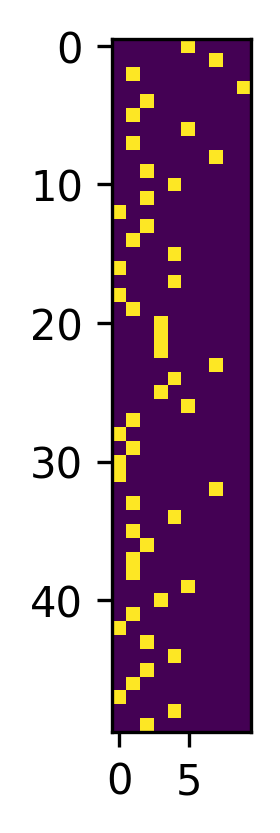

In [12]:
#Visualize the One-hot encoded Prediction Labels
import matplotlib.pyplot as plt
plt.figure(figsize=(9,3), dpi=300)
plt.imshow(y_train[:50])

Apply classification algorithms to the training data, tune on validation data (if present), and evaluate on test data.

You can also apply classification downstream of last week's autoencoder latent space representation. *italicized text*

In [13]:
y_train_1d = np.argmax(y_train, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

xgb_1 = XGBClassifier(n_estimators = 10, max_depth = 2)
xgb_2 = XGBClassifier(n_estimators = 50, max_depth = 3)
xgb_3 = XGBClassifier(n_estimators = 90, max_depth = 4)
xgb_4 = XGBClassifier(n_estimators = 130, max_depth = 5)


meta_model = LogisticRegression()

stacking_classifier = StackingClassifier(
    estimators=[('xgb1', xgb_1), ('xgb2', xgb_2), ('xgb3', xgb_3), ('xgb4', xgb_4)],
    final_estimator=meta_model,
    cv=5
    )



stacking_classifier.fit(X_train, y_train_1d)
y_pred = stacking_classifier.predict(X_test)

accuracy = accuracy_score(y_test_1d, y_pred)
print(f"Accuracy: {accuracy}")



Accuracy: 0.8142857142857143


In [14]:
accuracy = accuracy_score(y_test_1d, y_pred)
print(f"Model Accuracy (): {accuracy*100}%")

Model Accuracy (): 81.42857142857143%


In [18]:
print(classification_report(y_test_1d, y_pred, zero_division = 1))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81        30
           1       0.90      0.86      0.88        50
           2       0.80      0.67      0.73         6
           3       0.64      0.90      0.75        10
           4       1.00      0.93      0.97        15
           5       0.64      0.64      0.64        14
           6       1.00      0.00      0.00         1
           7       0.75      0.67      0.71         9
           8       1.00      0.00      0.00         2
           9       1.00      1.00      1.00         3

    accuracy                           0.81       140
   macro avg       0.85      0.65      0.65       140
weighted avg       0.83      0.81      0.81       140



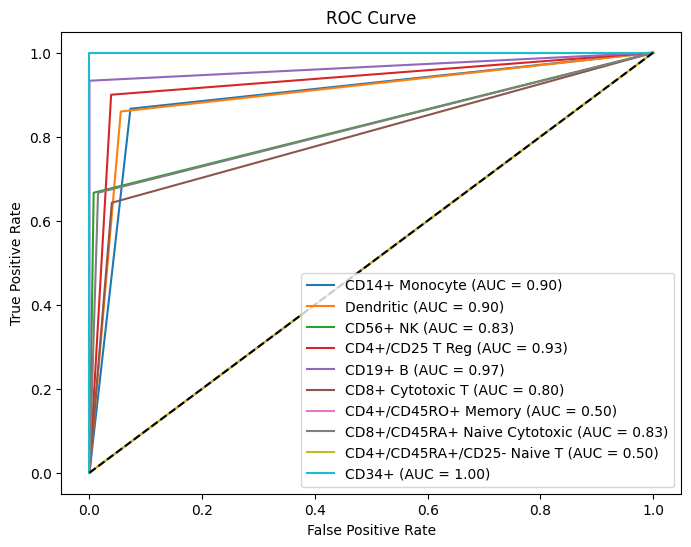

In [43]:
lb = LabelBinarizer()
y_test_ohe = lb.fit_transform(y_test_1d)
y_pred_ohe = lb.transform(y_pred)

fpr = []
tpr = []
roc_auc = []

for i in range(len(categories)):
    fpr_i, tpr_i, _ = roc_curve(y_test_ohe[:, i], y_pred_ohe[:, i])
    roc_auc_i = auc(fpr_i, tpr_i)
    fpr.append(fpr_i)
    tpr.append(tpr_i)
    roc_auc.append(roc_auc_i)

plt.figure(figsize=(8, 6))
for i in range(len(categories)):
    plt.plot(fpr[i], tpr[i], label=f'{categories[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
